In [2]:
import numpy as np
from tqdm import tqdm
import cv2

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ml_exercise_therapanacea.zip to ml_exercise_therapanacea.zip


In [ ]:
from zipfile import ZipFile
import os
file_name = "ml_exercise_therapanacea.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

In [8]:
import os
y=[]
os.chdir('/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea')
with open('label_train.txt', 'r') as f:
    y = [int(line.strip()) for line in f.readlines()]
print(f"Total: {len(y)}, Distribution: {np.bincount(y)}")

Total: 100000, Distribution: [12102 87898]


In [4]:
import os
from tqdm import tqdm
import cv2
import re
X=[]
os.chdir('train_img')
def numerical_sort(value):
    # extrait les nombres dans le nom du fichier
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else 0

files = sorted(os.listdir(), key=numerical_sort)

In [ ]:
# from tensorflow.keras.applications.mobilenet import preprocess_input
# target_size = (224, 224)

# for i in tqdm(files):
#     img = cv2.imread(i)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, target_size)
#     img = img.astype(np.float32)
#     img = preprocess_input(img)  # met entre -1 et 1
#     X.append(img)


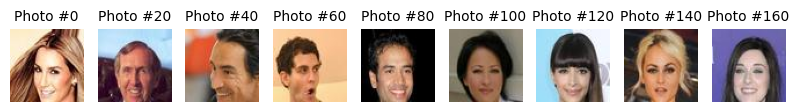

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(1, 9, i+1)
    image_index = i*20
    plt.imshow(X[image_index].astype('uint8'))
    plt.axis('off')
    plt.title(f'Photo #{image_index}', fontsize=10)
plt.show()

In [83]:
from sklearn.model_selection import train_test_split
import numpy as np

# Échantillonnage sur les indices seulement
sample_size = 50000
_, sample_indices = train_test_split(
    range(len(y)),
    test_size=sample_size,
    stratify=y,
    random_state=42
)

sample_indices = np.array(sample_indices)  # ← CORRECTION : convertir en array
sample_labels = y[sample_indices]
print(f"Échantillon: {len(sample_labels)}")

# Split train/val sur l'échantillon
train_indices_local, val_indices_local = train_test_split(
    range(len(sample_labels)),
    test_size=0.2,
    stratify=sample_labels,
    random_state=42
)

train_indices_local = np.array(train_indices_local)  # ← CORRECTION
val_indices_local = np.array(val_indices_local)     # ← CORRECTION

# Créer y_train et y_val
y_train = sample_labels[train_indices_local]
y_val = sample_labels[val_indices_local]

# Créer les vrais indices pour charger les images
train_sample_indices = sample_indices[train_indices_local]  # ← Maintenant ça marche
val_sample_indices = sample_indices[val_indices_local]

print(f"y_train: {len(y_train)}, y_val: {len(y_val)}")

Échantillon: 50000
y_train: 40000, y_val: 10000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

class_names = ['Classe 0', 'Classe 1']
random_indices = random.sample(range(len(X_train)), 6)

plt.figure(figsize=(18, 8))

for i, idx in enumerate(random_indices):
   # Image via X_train
   plt.subplot(2, 6, i+1)
   plt.imshow(X_train[idx])
   label = np.argmax(y_train[idx])
   original_idx = train_indices[idx]
   plt.title(f'X_train[{idx}]\nOriginal #{original_idx}\n{class_names[label]}', fontsize=9)
   plt.axis('off')

   # Image via X[original_idx] pour vérification
   plt.subplot(2, 6, i+7)
   plt.imshow(X[original_idx])
   label_original = np.argmax(y[original_idx])
   plt.title(f'X[{original_idx}]\nDirect access\n{class_names[label_original]}', fontsize=9)
   plt.axis('off')

plt.suptitle('Vérification: X_train vs X[original_idx]', fontsize=16)
plt.tight_layout()
plt.show()

In [1]:
from tensorflow.keras.applications import MobileNetV2

# Maintenant vos images sont déjà en 224x224
img_rows, img_cols = 224, 224

# Load MobileNetV2
mobilenet = MobileNetV2(weights='imagenet',
                       include_top=False,
                       input_shape=(img_rows, img_cols, 3))
# Freeze the layers
for layer in mobilenet.layers:
    layer.trainable = False


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
def lw(bottom_model, num_classes=None):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)  # 1 sortie pour binaire
    return top_model

In [ ]:
from tensorflow.keras.models import Model

num_classes = 2

FC_Head = lw(mobilenet)
model = Model(inputs = mobilenet.input, outputs = FC_Head)
print(model.summary())

In [49]:
# Au lieu de class_weight_dict calculé automatiquement
class_weight_dict = {0: 15.0, 1: 1.0}  # Beaucoup plus agressif !

# Ou calculer manuellement
total = len(y_train)
count_0 = np.sum(y_train == 0)
count_1 = np.sum(y_train == 1)

# Formule plus agressive
weight_0 = (total / count_0) * 2  # Multiplier par 2 ou 3
weight_1 = total / count_1

class_weight_dict = {0: weight_0, 1: weight_1}
print(f"Nouveaux poids: {class_weight_dict}")

Nouveaux poids: {0: np.float64(16.52892561983471), 1: np.float64(1.1376564277588168)}


In [13]:
# Compile the model with an optimizer and loss function
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
# from tensorflow.keras.optimizers import Adam
# # Learning rate beaucoup plus bas quand on dégèle des couches
# model.compile(optimizer=Adam(learning_rate=0.00001),  # Très bas !
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

#loss='binary_crossentropy',

In [52]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(f"Poids des classes: {class_weight_dict}")
os.chdir('/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/train_img')
files = sorted(os.listdir())

print(f"Nombre de fichiers: {len(files)}")
print(f"Premiers fichiers: {files[:5]}")

Poids des classes: {np.int64(0): np.float64(4.132231404958677), np.int64(1): np.float64(0.5688282138794084)}
Nombre de fichiers: 100000
Premiers fichiers: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


In [84]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

class StratifiedGenerator(Sequence):
    def __init__(self, indices, labels, batch_size=32, class_0_ratio=0.5):
        self.all_indices = indices
        self.all_labels = labels
        self.batch_size = batch_size
        self.class_0_ratio = class_0_ratio
        
        # Séparer les indices par classe
        self.class_0_indices = indices[labels == 0]
        self.class_1_indices = indices[labels == 1]
        
        # Calculer combien d'images de chaque classe par batch
        self.n_class_0_per_batch = int(batch_size * class_0_ratio)
        self.n_class_1_per_batch = batch_size - self.n_class_0_per_batch
        
        print(f"Distribution par batch: {self.n_class_0_per_batch} classe 0 + {self.n_class_1_per_batch} classe 1")
        print(f"Disponible: {len(self.class_0_indices)} classe 0, {len(self.class_1_indices)} classe 1")
        
        # Créer des pools d'indices réutilisables pour éviter l'épuisement
        self.epochs_completed = 0
        self._shuffle_indices()
        
    def _shuffle_indices(self):
        """Mélange et duplique les indices si nécessaire"""
        # Calculer combien de fois on doit répéter chaque classe pour avoir assez d'échantillons
        needed_0 = self.n_class_0_per_batch * 1000  # Pour 1000 batches
        needed_1 = self.n_class_1_per_batch * 1000
        
        repeat_0 = max(1, needed_0 // len(self.class_0_indices) + 1)
        repeat_1 = max(1, needed_1 // len(self.class_1_indices) + 1)
        
        # Créer des pools avec répétition
        self.shuffled_0 = np.tile(self.class_0_indices, repeat_0)
        self.shuffled_1 = np.tile(self.class_1_indices, repeat_1)
        
        # Mélanger
        np.random.shuffle(self.shuffled_0)
        np.random.shuffle(self.shuffled_1)
        
        # Compteurs
        self.idx_0 = 0
        self.idx_1 = 0
        
    def __len__(self):
        # Nombre de batches possible (limité par l'epoch)
        return min(200, len(self.all_indices) // self.batch_size)  # Limite à 200 batches par epoch
    
    def __getitem__(self, idx):
        # Vérifier s'il faut reshuffler
        if (self.idx_0 + self.n_class_0_per_batch >= len(self.shuffled_0) or 
            self.idx_1 + self.n_class_1_per_batch >= len(self.shuffled_1)):
            self._shuffle_indices()
        
        # Sélectionner les indices pour ce batch
        batch_0_indices = self.shuffled_0[self.idx_0:self.idx_0 + self.n_class_0_per_batch]
        batch_1_indices = self.shuffled_1[self.idx_1:self.idx_1 + self.n_class_1_per_batch]
        
        # Avancer les compteurs
        self.idx_0 += self.n_class_0_per_batch
        self.idx_1 += self.n_class_1_per_batch
        
        # Combiner et mélanger
        batch_indices = np.concatenate([batch_0_indices, batch_1_indices])
        np.random.shuffle(batch_indices)
        
        batch_x = []
        batch_y = []
        
        for i in batch_indices:
            img_path = f'/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/train_img/{files[i]}'
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                img = img.astype(np.float32)
                img = preprocess_input(img)
                batch_x.append(img)
                batch_y.append(y[i])
        
        return np.array(batch_x), np.array(batch_y)

# Créer les générateurs stratifiés
print("Création des générateurs stratifiés...")

# Pour l'entraînement : équilibrer les classes
train_gen = StratifiedGenerator(train_sample_indices, y_train, 
                               batch_size=32, class_0_ratio=0.5)  # 50/50

# Pour la validation : garder la distribution naturelle
val_class_0_ratio = np.sum(y_val == 0) / len(y_val)
val_gen = StratifiedGenerator(val_sample_indices, y_val, 
                             batch_size=32, class_0_ratio=val_class_0_ratio)

# Entraînement
print("\nEntraînement avec batches stratifiés...")
history = model.fit(train_gen,
                    epochs=2,
                    validation_data=val_gen,
                    verbose=1)
                    # Plus besoin de class_weight avec batches équilibrés !

print("Entraînement terminé !")

Création des générateurs stratifiés...
Distribution par batch: 16 classe 0 + 16 classe 1
Disponible: 4841 classe 0, 35159 classe 1
Distribution par batch: 3 classe 0 + 29 classe 1
Disponible: 1210 classe 0, 8790 classe 1

Entraînement avec batches stratifiés...
Epoch 1/2


/Users/macbookair/Library/Python/3.11/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 769ms/step - accuracy: 0.8588 - loss: 0.3880 - val_accuracy: 0.8695 - val_loss: 0.2868
Epoch 2/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 149s 748ms/step - accuracy: 0.8561 - loss: 0.3347 - val_accuracy: 0.8923 - val_loss: 0.2582
Entraînement terminé !


In [85]:
from sklearn.metrics import confusion_matrix
import numpy as np

def test_hter_only():
    """Teste différents seuils et affiche seulement HTER"""
    print("\n" + "="*50)
    print("TEST HTER POUR DIFFÉRENTS SEUILS")
    print("="*50)
    
    all_y_true = []
    all_y_pred_proba = []
    
    # Collecter toutes les probabilités
    for i in range(len(val_gen)):
        X_batch, y_batch = val_gen[i]
        y_pred_batch = model.predict(X_batch, verbose=0)
        
        if y_pred_batch.shape[1] == 1:
            proba_class_0 = y_pred_batch.flatten()
        else:
            proba_class_0 = y_pred_batch[:, 0]
            
        all_y_true.extend(y_batch)
        all_y_pred_proba.extend(proba_class_0)
    
    all_y_true = np.array(all_y_true)
    all_y_pred_proba = np.array(all_y_pred_proba)
    
    # Générer beaucoup de seuils entre 0.1 et 0.9
    thresholds = np.arange(0.1, 0.91, 0.02)  # De 0.1 à 0.9 par pas de 0.02
    
    print(f"{'Seuil':<8} {'HTER':<8}")
    print("-" * 20)
    
    best_hter = 1.0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (all_y_pred_proba > threshold).astype(int)
        
        try:
            # Calculer HTER
            cm = confusion_matrix(all_y_true, y_pred)
            
            if cm.sum() > 0:
                frr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
                far = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
                hter = (far + frr) / 2
            else:
                hter = 1.0
            
            print(f"{threshold:<8.2f} {hter:<8.4f}")
            
            # Garder le meilleur seuil pour HTER
            if hter < best_hter:
                best_hter = hter
                best_threshold = threshold
                
        except Exception as e:
            print(f"{threshold:<8.2f} Erreur")
    
    print(f"\n🎯 MEILLEUR SEUIL: {best_threshold:.2f} (HTER: {best_hter:.4f})")
    
    return best_threshold, best_hter

# Test des seuils pour HTER seulement
best_threshold, best_hter = test_hter_only()


TEST HTER POUR DIFFÉRENTS SEUILS
Seuil    HTER    
--------------------
0.10     0.2408  
0.12     0.2233  
0.14     0.2090  
0.16     0.2025  
0.18     0.1905  
0.20     0.1865  
0.22     0.1722  
0.24     0.1683  
0.26     0.1610  
0.28     0.1568  
0.30     0.1465  
0.32     0.1414  
0.34     0.1401  
0.36     0.1397  
0.38     0.1324  
0.40     0.1306  
0.42     0.1259  
0.44     0.1201  
0.46     0.1206  
0.48     0.1184  
0.50     0.1162  
0.52     0.1158  
0.54     0.1110  
0.56     0.1130  
0.58     0.1170  
0.60     0.1200  
0.62     0.1227  
0.64     0.1248  
0.66     0.1287  
0.68     0.1311  
0.70     0.1346  
0.72     0.1382  
0.74     0.1461  
0.76     0.1540  
0.78     0.1589  
0.80     0.1657  
0.82     0.1690  
0.84     0.1769  
0.86     0.1862  
0.88     0.1999  
0.90     0.2122  

🎯 MEILLEUR SEUIL: 0.54 (HTER: 0.1110)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def test_hter_val_images():
    """Teste différents seuils HTER sur les 1000 premières images de val_img"""
    print("\n" + "="*60)
    print("TEST HTER SUR LES 1000 PREMIÈRES IMAGES DE VAL_IMG")
    print("="*60)
    
    # Vos indices de classe 0 pour les 1000 premières images de val_img
    true_class_0_indices = [2,11,16,19,20,30,32,39,48,53,54,63,74,78,81,88,90,94,109,
                            121,126,127,143,148,171,175,178,182,190,192,198,222,226,
                            230,292,301,313,316,318,343,356,357,358,369,370,380,416,
                            420,423,426,428,440,457,460,479,488,491,494,500,512,515,
                            518,522,525,526,537,545,548,549,551,553,566,567,582,589,
                            590,595,600,602,609,613,661,664,685,700,704,711,712,723,724,
                            726,728,739,861,867,869,874,886,888,889,893,895,903,904,
                            940,944,949,977,978,999]
    
    # Créer le vecteur de vrais labels
    y_true = np.ones(1000)  # Par défaut classe 1
    for idx in true_class_0_indices:
        y_true[idx - 1] = 0  # Convertir 1-based vers 0-based
    
    # Charger les probabilités depuis le modèle (refaire les prédictions pour avoir les probas)
    val_directory = '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/val_img'
    os.chdir(val_directory)
    all_files = sorted([f for f in os.listdir() if f.endswith('.jpg')])[:1000]
    
    print("Récupération des probabilités...")
    all_y_pred_proba = []
    
    for filename in tqdm(all_files, desc="Calcul probas"):
        try:
            img = cv2.imread(filename)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                img = img.astype(np.float32)
                img = preprocess_input(img)
                img_batch = np.expand_dims(img, axis=0)
                
                pred_proba = model.predict(img_batch, verbose=0)[0, 0]
                all_y_pred_proba.append(pred_proba)
            else:
                all_y_pred_proba.append(0.5)  # Défaut
        except:
            all_y_pred_proba.append(0.5)  # Défaut
    
    all_y_pred_proba = np.array(all_y_pred_proba)
    
    # Générer beaucoup de seuils entre 0.1 et 0.9
    thresholds = np.arange(0.1, 0.91, 0.02)  # De 0.1 à 0.9 par pas de 0.02
    
    print(f"\n{'Seuil':<8} {'HTER':<8}")
    print("-" * 20)
    
    best_hter = 1.0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (all_y_pred_proba > threshold).astype(int)
        
        try:
            # Calculer HTER
            cm = confusion_matrix(y_true, y_pred)
            
            if cm.sum() > 0:
                frr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
                far = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
                hter = (far + frr) / 2
            else:
                hter = 1.0
            
            print(f"{threshold:<8.2f} {hter:<8.4f}")
            
            # Garder le meilleur seuil pour HTER
            if hter < best_hter:
                best_hter = hter
                best_threshold = threshold
                
        except Exception as e:
            print(f"{threshold:<8.2f} Erreur")
    
    print(f"\n🎯 MEILLEUR SEUIL: {best_threshold:.2f} (HTER: {best_hter:.4f})")
    
    return best_threshold, best_hter

# Test des seuils pour HTER sur val_img
best_threshold, best_hter = test_hter_val_images()


TEST HTER SUR LES 1000 PREMIÈRES IMAGES DE VAL_IMG
Récupération des probabilités...


Calcul probas: 100%|██████████| 1000/1000 [01:04<00:00, 15.46it/s]


Seuil    HTER    
--------------------
0.10     0.2574  
0.12     0.2312  
0.14     0.2244  
0.16     0.1948  
0.18     0.1840  
0.20     0.1686  
0.22     0.1601  
0.24     0.1572  
0.26     0.1509  
0.28     0.1452  
0.30     0.1469  
0.32     0.1486  
0.34     0.1463  
0.36     0.1457  
0.38     0.1405  
0.40     0.1376  
0.42     0.1410  
0.44     0.1347  
0.46     0.1369  
0.48     0.1346  
0.50     0.1380  
0.52     0.1363  
0.54     0.1271  
0.56     0.1311  
0.58     0.1197  
0.60     0.1270  
0.62     0.1292  
0.64     0.1337  
0.66     0.1336  
0.68     0.1392  
0.70     0.1465  
0.72     0.1475  
0.74     0.1532  
0.76     0.1582  
0.78     0.1587  
0.80     0.1637  
0.82     0.1727  
0.84     0.1788  
0.86     0.1912  
0.88     0.1995  
0.90     0.2175  

🎯 MEILLEUR SEUIL: 0.58 (HTER: 0.1197)


In [88]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tqdm import tqdm

def predict_all_val_images(model, val_dir, threshold=0.56, output_file='all_predictions.txt'):
    """
    Fait les prédictions sur TOUTES les images de val_img avec le seuil spécifié
    """
    # Calculer le chemin du dossier parent pour sauvegarder
    parent_dir = os.path.dirname(val_dir)
    output_path = os.path.join(parent_dir, output_file)
    
    # Aller dans le dossier val_img
    os.chdir(val_dir)
    
    # Lister et trier TOUS les fichiers .jpg
    all_files = sorted([f for f in os.listdir() if f.endswith('.jpg')])
    
    print(f"Prédiction sur TOUTES les images de val_img...")
    print(f"Nombre total d'images: {len(all_files)}")
    print(f"Première image: {all_files[0]}")
    print(f"Dernière image: {all_files[-1]}")
    print(f"Seuil utilisé: {threshold}")
    
    predictions = []
    
    # Faire les prédictions sur toutes les images
    for i, filename in enumerate(tqdm(all_files, desc="label_val")):
        try:
            # Charger l'image
            img = cv2.imread(filename)
            if img is not None:
                # Preprocessing identique à l'entraînement
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                img = img.astype(np.float32)
                img = preprocess_input(img)
                
                # Ajouter dimension batch
                img_batch = np.expand_dims(img, axis=0)
                
                # Prédiction
                pred_proba = model.predict(img_batch, verbose=0)[0, 0]  # Sigmoid output
                pred_class = 1 if pred_proba > threshold else 0
                
                predictions.append(pred_class)
            else:
                print(f"Erreur lecture: {filename}")
                predictions.append(0)  # Valeur par défaut
                
        except Exception as e:
            print(f"Erreur avec {filename}: {e}")
            predictions.append(0)
    
    # Sauvegarder dans le fichier texte dans le dossier parent
    with open(output_path, 'w') as f:
        for i, pred in enumerate(predictions):
            f.write(f"{pred}\n")  # Ligne i+1 = prédiction pour image i+1
    
    print(f"\nPrédictions sauvegardées dans: {output_path}")
    print(f"Format: ligne N = prédiction pour image N")
    print(f"Exemple: ligne 1 = prédiction pour {all_files[0]}")
    print(f"         ligne {len(all_files)} = prédiction pour {all_files[-1]}")
    
    # Statistiques
    pred_array = np.array(predictions)
    print(f"\nStatistiques des prédictions sur {len(predictions)} images:")
    print(f"Classe 0 (avec accessoires): {np.sum(pred_array == 0)} images ({np.mean(pred_array == 0)*100:.1f}%)")
    print(f"Classe 1 (sans accessoires): {np.sum(pred_array == 1)} images ({np.mean(pred_array == 1)*100:.1f}%)")
    
    return predictions

# Utilisation
val_directory = '/Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/val_img'
all_predictions = predict_all_val_images(
    model=model,
    val_dir=val_directory,
    threshold=0.56,  # Votre seuil optimal
    output_file='all_val_predictions.txt'
)

print("Terminé ! Le fichier all_val_predictions.txt contient les prédictions pour TOUTES les images de val_img.")

Prédiction sur TOUTES les images de val_img...
Nombre total d'images: 20000
Première image: 000001.jpg
Dernière image: 020000.jpg
Seuil utilisé: 0.56


label_val: 100%|██████████| 20000/20000 [22:56<00:00, 14.53it/s]  


Prédictions sauvegardées dans: /Users/macbookair/Desktop/therapanacea/ml_exercise_therapanacea/all_val_predictions.txt
Format: ligne N = prédiction pour image N
Exemple: ligne 1 = prédiction pour 000001.jpg
         ligne 20000 = prédiction pour 020000.jpg

Statistiques des prédictions sur 20000 images:
Classe 0 (avec accessoires): 4292 images (21.5%)
Classe 1 (sans accessoires): 15708 images (78.5%)
Terminé ! Le fichier all_val_predictions.txt contient les prédictions pour TOUTES les images de val_img.


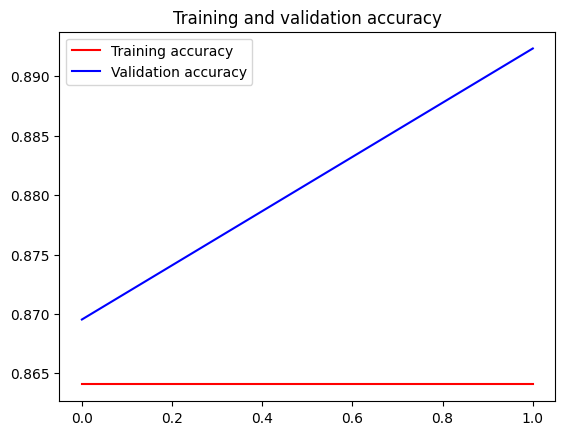

<Figure size 640x480 with 0 Axes>

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()